Loaded 25000 images.
Class distribution: {np.int64(0): np.int64(12500), np.int64(1): np.int64(12500)}
HOG features extracted: Train shape = (20000, 216), Test shape = (5000, 216)
Accuracy: 0.7708

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      2500
           1       0.77      0.78      0.77      2500

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



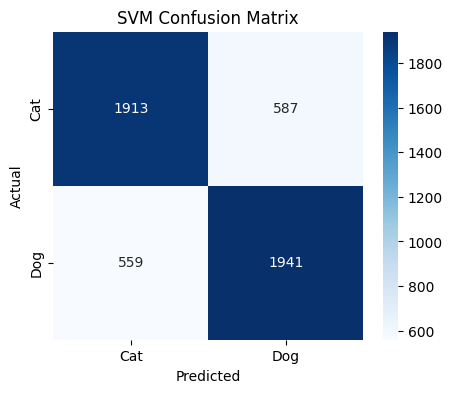

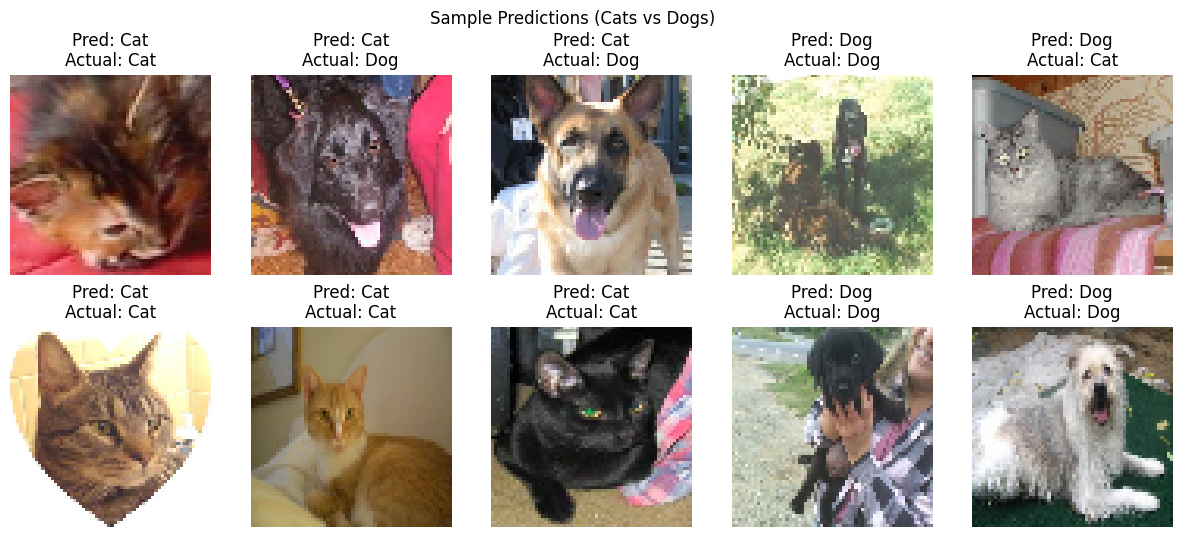

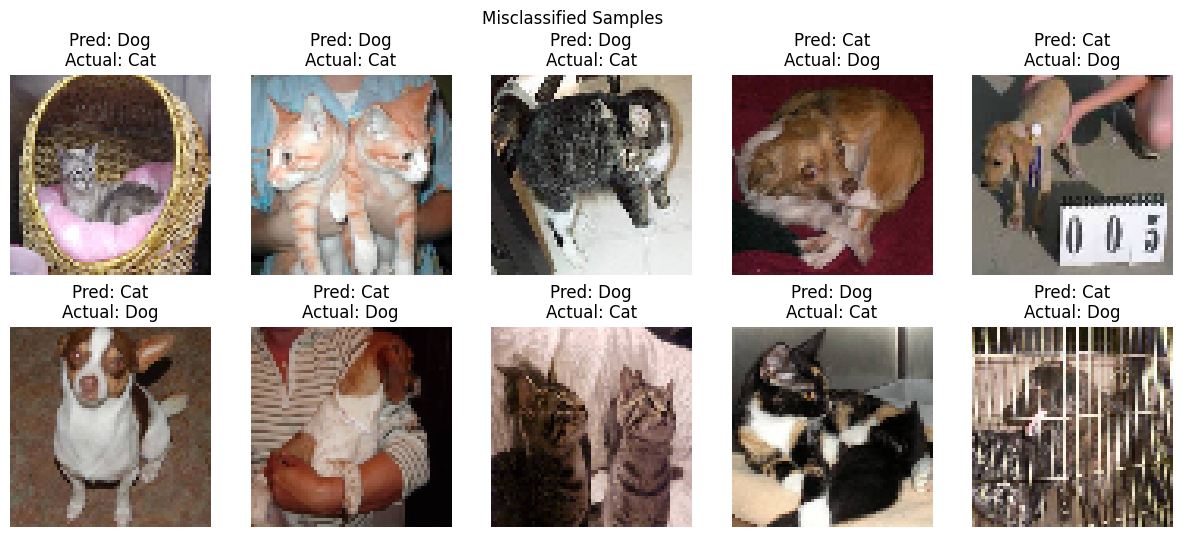

In [14]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")

#loading images and assigning the labels
def load_images_from_folder(folder, img_size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            if "cat" in filename.lower():
                labels.append(0) #0 for cat
            elif "dog" in filename.lower():
                labels.append(1) #1 for dog
    return np.array(images), np.array(labels)

dataset_path = "train_for_SVM/train_for_SVM"
X_images, y_labels = load_images_from_folder(dataset_path)
print(f"Loaded {len(X_images)} images.")

#Distribution of no of classes
uni, counts = np.unique(y_labels, return_counts=True)
print("Class distribution:", dict(zip(uni, counts)))

#split for training and testing
X_train_img, X_test_img, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

#Extracting HOG features
def extract_hog_features(images):
    hog_features = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        features = hog(gray,orientations=6,pixels_per_cell=(16, 16),cells_per_block=(2, 2),block_norm='L2-Hys',visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

X_train = extract_hog_features(X_train_img)
X_test = extract_hog_features(X_test_img)
print(f"HOG features extracted: Train shape = {X_train.shape}, Test shape = {X_test.shape}")

#SVM classifier -- rbf for (effectively handles non-linearly separable data)
svm_clf = SVC(kernel='rbf', gamma='scale', C=1.0)
svm_clf.fit(X_train, y_train)

#Prediction and evaluation 
y_pred = svm_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

# Visualizing the predictions
indices = random.sample(range(len(X_test_img)), 10)
plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    img = X_test_img[idx]
    pred = y_pred[idx]
    actual = y_test[idx]
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Pred: {'Dog' if pred==1 else 'Cat'}\nActual: {'Dog' if actual==1 else 'Cat'}")
    plt.axis("off")
plt.suptitle("Sample Predictions (Cats vs Dogs)")
plt.show()

#Misclassified images visualization
misclassified_indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
plt.figure(figsize=(15, 6))
for i, idx in enumerate(misclassified_indices[:10]):  # first 10
    img = X_test_img[idx]
    pred = y_pred[idx]
    actual = y_test[idx]
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Pred: {'Dog' if pred==1 else 'Cat'}\nActual: {'Dog' if actual==1 else 'Cat'}")
    plt.axis("off")
plt.suptitle("Misclassified Samples")
plt.show()


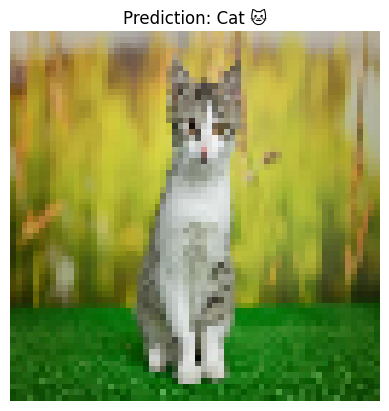

✅ Final Prediction: Cat 🐱


In [12]:
import cv2
from skimage.feature import hog

def predict_image(image_path, model, img_size=(64, 64)):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print("⚠️ Could not load image!")
        return
    
    # Preprocess (resize + grayscale)
    img_resized = cv2.resize(img, img_size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features (same params as training)
    features = hog(
        gray, orientations=6,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )
    
    # Reshape for prediction
    features = features.reshape(1, -1)
    
    # Predict
    prediction = model.predict(features)[0]
    label = "Dog 🐶" if prediction == 1 else "Cat 🐱"
    
    # Show image + result
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {label}")
    plt.axis("off")
    plt.show()
    
    return label

# ---------------------------
# 🔹 Example usage
# ---------------------------
test_img_path = r"C:\Users\vijay\train_for_SVM\train_for_SVM\test_image.jpg"


result = predict_image(test_img_path, svm_clf)
print("✅ Final Prediction:", result)
